In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import randint as sp_randint


In [6]:

# Load Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)


In [7]:

# Feature engineering
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'].fillna('S', inplace=True)
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['Age'] = SimpleImputer(strategy='mean').fit_transform(df[['Age']])
X = df[features]
y = df['Survived']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# KNN & hyperparameter search
knn = KNeighborsClassifier()
param_dist = {
    'n_neighbors': sp_randint(10, 50),
    'weights': ['distance'],
    'p': [1, 2],
    'leaf_size': sp_randint(10, 50)
}



C:\Users\msi\AppData\Local\Temp\ipykernel_7848\3399491079.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna('S', inplace=True)


In [8]:
random_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='accuracy',
                                   random_state=42, n_jobs=-1, return_train_score=True)

random_search.fit(X_train, y_train)
best_knn = random_search.best_estimator_

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5)
print("Cross-validation Accuracy: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))

# Predict on test set
y_pred = best_knn.predict(X_test)

# Accuracy and classification report
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Hyperparameters: {'leaf_size': 16, 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
Cross-validation Accuracy: 0.8104 ± 0.0164

Test Set Accuracy: 0.7821229050279329
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



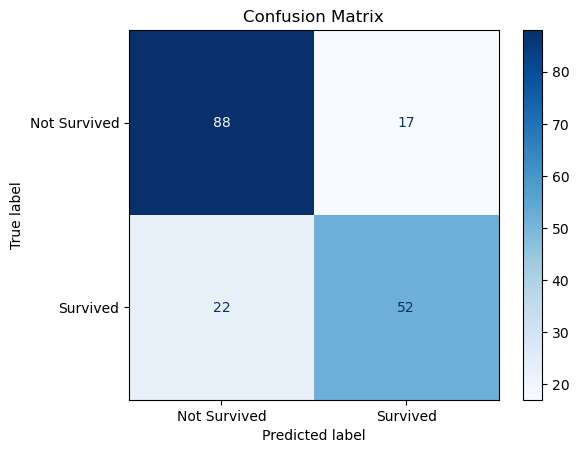

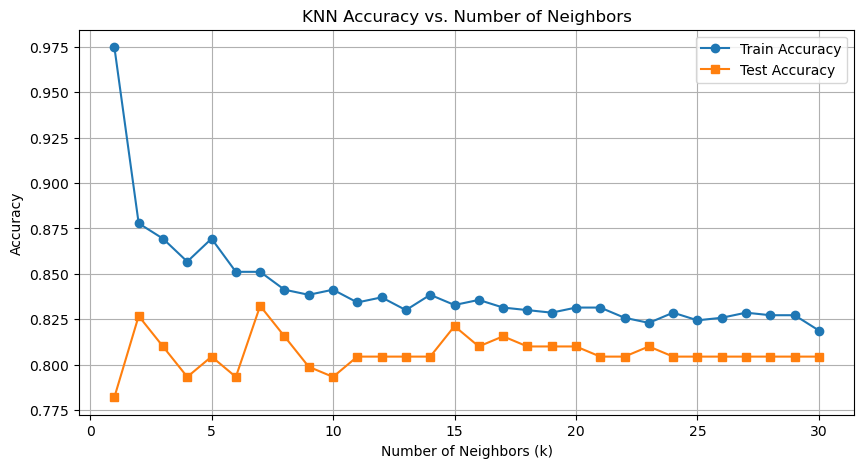

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Accuracy plot across different neighbors 
neighbors = list(range(1, 31))
train_accuracies = []
test_accuracies = []

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(neighbors, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(neighbors, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()




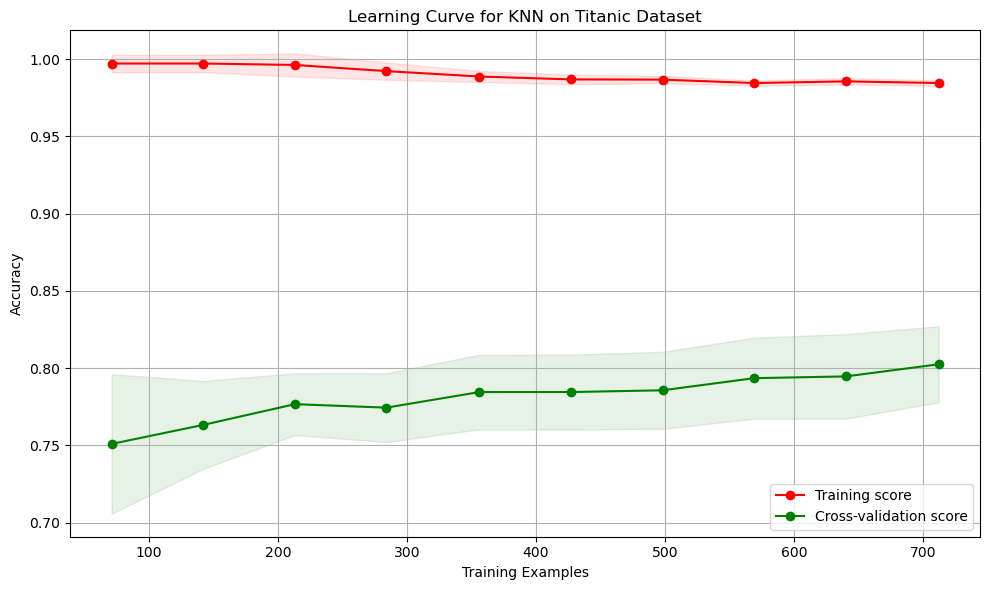

In [12]:
from sklearn.model_selection import learning_curve

# Plot learning curve for best_knn
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the learning curve
plot_learning_curve(best_knn, X_scaled, y, title="Learning Curve for KNN on Titanic Dataset")
